### Imports et configuration de base

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### Préparation du dataset

In [2]:
def prepare_tips_dataset(n_datasets=500):
    import seaborn as sns
    import pandas as pd
    import numpy as np

    tips = sns.load_dataset('tips')

    # Explicit type conversion for each column
    tips['total_bill'] = tips['total_bill'].astype(np.float64)
    tips['tip'] = tips['tip'].astype(np.float64)
    tips['size'] = tips['size'].astype(np.int32)

    # Manual encoding with explicit types
    tips['sex'] = tips['sex'].map({'Female': 1, 'Male': 0}).astype(np.int32)
    tips['smoker'] = tips['smoker'].map({'Yes': 1, 'No': 0}).astype(np.int32)
    tips['time'] = tips['time'].map({'Dinner': 1, 'Lunch': 0}).astype(np.int32)
    tips['day'] = tips['day'].map({
        'Thur': 0,
        'Fri': 1,
        'Sat': 2,
        'Sun': 3
    }).astype(np.int32)

    feature_cols = ['sex', 'smoker', 'day', 'time', 'size', 'tip']
    X = tips[feature_cols]
    y = tips['total_bill']

    return X.values, y.values



### Extraction des méta-caractéristiques

In [3]:

def extract_meta_features_multi(X, y):
    meta_features = []
    for i in range(X.shape[1]):
        x_col = X[:, i]
        std_val = np.std(x_col)
        if std_val == 0 or np.isnan(std_val):
            skewness = 0
            correlation = 0
        else:
            skewness = np.mean(((x_col - np.mean(x_col)) / std_val)**3)
            correlation = np.corrcoef(x_col, y)[0, 1]
        meta_features.append({
            'Feature': f'X{i}',
            'mean': np.mean(x_col),
            'std': std_val,
            'range': np.max(x_col) - np.min(x_col),
            'skew': skewness,
            'correlation_with_y': correlation
        })
    y_std = np.std(y)
    y_skewness = 0 if y_std == 0 else np.mean(((y - np.mean(y)) / y_std)**3)
    meta_features.append({
        'Feature': 'y',
        'mean': np.mean(y),
        'std': y_std,
        'range': np.max(y) - np.min(y),
        'skew': y_skewness,
        'correlation_with_y': None
    })
    return pd.DataFrame(meta_features)


### Classe AdvancedMetaLearner

In [4]:

class AdvancedMetaLearner:
    def __init__(self, model_type='rf', n_features=2):
        self.model_type = model_type
        self.n_features = n_features
        self.scaler = StandardScaler()
        self.models = [
            RandomForestRegressor(n_estimators=100, max_depth=10) if model_type == 'rf' else SVR(kernel='rbf', C=1.0, epsilon=0.1)
            for _ in range(n_features + 1)
        ]

    def train(self, meta_features, optimal_params):
        meta_features = np.nan_to_num(meta_features)
        X_scaled = self.scaler.fit_transform(meta_features)
        for i in range(self.n_features + 1):
            self.models[i].fit(X_scaled, optimal_params[:, i])

    def predict(self, meta_features):
        meta_features = np.nan_to_num(meta_features)
        X_scaled = self.scaler.transform(meta_features.reshape(1, -1))
        return [model.predict(X_scaled)[0] for model in self.models]


### Évaluation du système de méta-apprentissage

In [5]:

def evaluate_meta_learning_system():
    X_full, y_full = prepare_tips_dataset()
    n_features = X_full.shape[1]
    meta_features, optimal_params = [], []
    n_samples = len(X_full)
    subset_size = n_samples // 10

    for i in range(0, n_samples, subset_size):
        X_subset = X_full[i:i+subset_size]
        y_subset = y_full[i:i+subset_size]
        meta = extract_meta_features_multi(X_subset, y_subset)
        meta_values = meta.iloc[:-1, 1:].values.flatten()
        if not np.any(np.isnan(meta_values)):
            meta_features.append(meta_values)
            coefficients = np.random.uniform(0.5, 2.0, size=n_features)
            b = np.random.uniform(0.5, 2.0)
            optimal_params.append(np.append(coefficients, b))

    meta_features = np.array(meta_features)
    optimal_params = np.array(optimal_params)

    X_train, X_val, y_train, y_val = train_test_split(meta_features, optimal_params, test_size=0.2, random_state=42)

    rf_meta_learner = AdvancedMetaLearner(model_type='rf', n_features=n_features)
    svr_meta_learner = AdvancedMetaLearner(model_type='svr', n_features=n_features)
    rf_meta_learner.train(X_train, y_train)
    svr_meta_learner.train(X_train, y_train)

    X_test, y_test = X_full[:100], y_full[:100]
    meta_dict = extract_meta_features_multi(X_test, y_test)
    combined_features = [
        val for feature_num in range(n_features)
        for val in meta_dict.loc[meta_dict['Feature'] == f'X{feature_num}'].iloc[:, 1:].values.flatten()
    ]
    test_meta_features = np.array(combined_features)

    predictions_rf = rf_meta_learner.predict(test_meta_features)
    predictions_svr = svr_meta_learner.predict(test_meta_features)

    return X_test, y_test, predictions_rf[:-1], predictions_rf[-1], predictions_svr[:-1], predictions_svr[-1]


### Entraînement linéaire par descente de gradient

In [6]:

def train_linear_regression(X, y, coefficients_init, b_init, epochs=500, learning_rate=0.0001):
    X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-8)  # Standardiser les données
    coefficients = coefficients_init.copy()
    b = b_init
    losses = []
    for _ in range(epochs):
        y_pred = np.dot(X, coefficients) + b
        loss = np.mean((y - y_pred)**2)
        losses.append(loss)
        D_coefficients = -2 * np.mean(X * (y - y_pred)[:, np.newaxis], axis=0)
        Db = -2 * np.mean(y - y_pred)
        coefficients -= learning_rate * D_coefficients
        b -= learning_rate * Db
    return coefficients, b, losses


### Comparaison des approches

=== Initialisations ===

Initialisation aléatoire :
Coefficients initiaux : [0.44757578 0.16210231 0.50630844 0.06465471 0.62497055 0.00964553]
Biais initial : 0.11881216472302203

Initialisation par Random Forest :
Coefficients initiaux : [1.2260849346252232, 0.9583717913074756, 1.4695696800046867, 0.9396425809791886, 1.1277150011618062, 1.3630222280697037]
Biais initial : 1.332367456242979

Initialisation par SVR :
Coefficients initiaux : [1.3279679415843346, 0.9444851895707387, 1.597600259862928, 0.8852908124922372, 1.110095190818855, 1.2212597522069972]
Biais initial : 1.408922171372112

=== Résultats après descente de gradient ===

Résultats avec initialisation aléatoire :
Coefficients finaux : [ 0.3696867   0.20097148  0.37994699 -0.03978678  0.99186814  0.57028324]
Biais final : 1.9744579608024948

Résultats avec initialisation par Random Forest :
Coefficients finaux : [1.07438996 0.95266303 1.2078109  0.68481808 1.37479513 1.79562672]
Biais final : 3.072517215313526

Résultats 

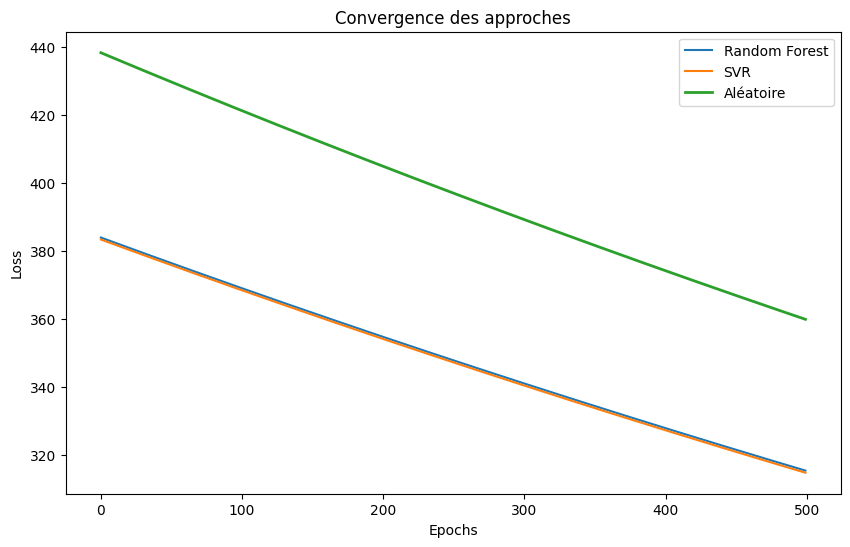

In [7]:
# Comparaison des approches
X_test, y_test, a_rf, b_rf, a_svr, b_svr = evaluate_meta_learning_system()

# Initialisation aléatoire
random_coefficients = np.random.rand(X_test.shape[1])
random_bias = np.random.rand()

print("=== Initialisations ===")
print("\nInitialisation aléatoire :")
print("Coefficients initiaux :", random_coefficients)
print("Biais initial :", random_bias)

print("\nInitialisation par Random Forest :")
print("Coefficients initiaux :", a_rf)
print("Biais initial :", b_rf)

print("\nInitialisation par SVR :")
print("Coefficients initiaux :", a_svr)
print("Biais initial :", b_svr)

# Entraînement avec descente de gradient
coeff_rf, bias_rf, losses_rf = train_linear_regression(X_test, y_test, a_rf, b_rf)
coeff_svr, bias_svr, losses_svr = train_linear_regression(X_test, y_test, a_svr, b_svr)
coeff_rand, bias_rand, losses_rand = train_linear_regression(X_test, y_test, random_coefficients, random_bias)

# Résultats finaux
print("\n=== Résultats après descente de gradient ===")
print("\nRésultats avec initialisation aléatoire :")
print("Coefficients finaux :", coeff_rand)
print("Biais final :", bias_rand)

print("\nRésultats avec initialisation par Random Forest :")
print("Coefficients finaux :", coeff_rf)
print("Biais final :", bias_rf)

print("\nRésultats avec initialisation par SVR :")
print("Coefficients finaux :", coeff_svr)
print("Biais final :", bias_svr)

# Courbes de convergence
plt.figure(figsize=(10, 6))
plt.plot(losses_rf, label="Random Forest")
plt.plot(losses_svr, label="SVR")
plt.plot(losses_rand, label="Aléatoire", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Convergence des approches")
plt.show()